In [1]:
from typing import List, Tuple

import keras.backend as K
import keras.layers
from keras import optimizers
from keras.engine.topology import Layer
from keras.layers import Activation, Lambda
from keras.layers import Conv1D, SpatialDropout1D
from keras.layers import Convolution1D, Dense
from keras.models import Input, Model
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


## 定義TCN

In [123]:
def residual_block(x, dilation_rate, nb_filters, kernel_size, padding, dropout_rate=0): 
    #residual_block其中一層
    # type: (Layer, int, int, int, str, float) -> Tuple[Layer, Layer]
    """Defines the residual block for the WaveNet TCN
    Args:
        x: The previous layer in the model 
        dilation_rate: The dilation power of 2 we are using for this residual block
        nb_filters: The number of convolutional filters to use in this block
        kernel_size: The size of the convolutional kernel
        padding: The padding used in the convolutional layers, 'same' or 'causal'.
        dropout_rate: Float between 0 and 1. Fraction of the input units to drop.
    Returns:
        A tuple where the first element is the residual model layer, and the second
        is the skip connection.
    """
    prev_x = x
    for k in range(2): #block設計
        x = Conv1D(filters=nb_filters,
                   kernel_size=kernel_size,
                   dilation_rate=dilation_rate,
                   padding=padding)(x)
        #x = BatchNormalization()(x)  # TODO should be WeightNorm here.
        x = Activation('relu')(x)
        x = SpatialDropout1D(rate=dropout_rate)(x)

    # 1x1 conv to match the shapes (channel dimension).
    prev_x = Conv1D(nb_filters, 1, padding='same')(prev_x)
    res_x = keras.layers.add([prev_x, x])
    return res_x, x


def process_dilations(dilations):
    def is_power_of_two(num):
        return num != 0 and ((num & (num - 1)) == 0)

    if all([is_power_of_two(i) for i in dilations]):
        return dilations

    else:
        new_dilations = [2 ** i for i in dilations]
        # print(f'Updated dilations from {dilations} to {new_dilations} because of backwards compatibility.')
        return new_dilations


class TCN:
    """Creates a TCN layer.
        Input shape:
            A tensor of shape (batch_size, timesteps, input_dim).
        Args:
            nb_filters: The number of filters to use in the convolutional layers.
            kernel_size: The size of the kernel to use in each convolutional layer.
            dilations: The list of the dilations. Example is: [1, 2, 4, 8, 16, 32, 64].
            nb_stacks : The number of stacks of residual blocks to use.( # of residual)
            padding: The padding to use in the convolutional layers, 'causal' or 'same'.
            use_skip_connections: Boolean. If we want to add skip connections from input to each residual block.
            return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence.
            dropout_rate: Float between 0 and 1. Fraction of the input units to drop.
            name: Name of the model. Useful when having multiple TCN.
        Returns:
            A TCN layer.
        """

    def __init__(self,
                 nb_filters=64,
                 kernel_size=2,
                 nb_stacks=1, #  num ofresidual block
                 dilations=[1, 2, 4, 8, 16, 32],
                 padding='causal',
                 use_skip_connections=True,
                 dropout_rate=0.0,
                 return_sequences=False,
                 name='tcn'):
        self.name = name
        self.return_sequences = return_sequences
        self.dropout_rate = dropout_rate
        self.use_skip_connections = use_skip_connections
        self.dilations = dilations
        self.nb_stacks = nb_stacks
        self.kernel_size = kernel_size
        self.nb_filters = nb_filters
        self.padding = padding

        if padding != 'causal' and padding != 'same':
            raise ValueError("Only 'causal' or 'same' padding are compatible for this layer.")

        if not isinstance(nb_filters, int):
            print('An interface change occurred after the version 2.1.2.')
            print('Before: tcn.TCN(x, return_sequences=False, ...)')
            print('Now should be: tcn.TCN(return_sequences=False, ...)(x)')
            print('The alternative is to downgrade to 2.1.2 (pip install keras-tcn==2.1.2).')
            raise Exception()

    def __call__(self, inputs):
        x = inputs #shape = (N,t,d)
        print('x.shape = ',x.shape  ) #
        x = Convolution1D(self.nb_filters, 1, padding=self.padding)(x) #(N,new _t,FN)
        print('x.shape = ',x.shape  ) #
        skip_connections = []
        for s in range(self.nb_stacks): #幾個block
            for d in self.dilations: #一個block的layers
                '''
                x：經過redual_layer + con1D(X)出來的值 
                skip_out：經過redual_layer
                '''
                x, skip_out = residual_block(x,       
                                             dilation_rate=d,
                                             nb_filters=self.nb_filters,
                                             kernel_size=self.kernel_size,
                                             padding=self.padding,
                                             dropout_rate=self.dropout_rate)
                skip_connections.append(skip_out)
            print('skip_out.shape',skip_out.shape)
        if self.use_skip_connections: #若使用skip
            x = keras.layers.add(skip_connections)
        if not self.return_sequences: # 0：只拿出最後一個時間做考慮
            x = Lambda(lambda tt: tt[:, -1, :])(x)
        return x


def compiled_tcn(num_feat,  # type: int
                 num_classes,  # type: int
                 nb_filters,  # type: int
                 kernel_size,  # type: int
                 dilations,  # type: List[int]
                 nb_stacks,  # type: int
                 max_len,  # type: int
                 padding='causal',  # type: str
                 use_skip_connections=True,  # type: bool
                 return_sequences=True,
                 regression=False,  # type: bool
                 dropout_rate=0.05,  # type: float
                 name='tcn',  # type: str,
                 opt='adam',
                 lr=0.002):
    # type: (...) -> keras.Model
    """Creates a compiled TCN model for a given task (i.e. regression or classification).
    Classification uses a sparse categorical loss. Please input class ids and not one-hot encodings.
    Args:
        num_feat: The number of features of your input, i.e. the last dimension of: (batch_size, timesteps, input_dim).
        num_classes: The size of the final dense layer, how many classes we are predicting.
        nb_filters: The number of filters to use in the convolutional layers.
        kernel_size: The size of the kernel to use in each convolutional layer.
        dilations: The list of the dilations. Example is: [1, 2, 4, 8, 16, 32, 64].
        nb_stacks : The number of stacks of residual blocks to use.
        max_len: The maximum sequence length, use None if the sequence length is dynamic.
        padding: The padding to use in the convolutional layers.
        use_skip_connections: Boolean. If we want to add skip connections from input to each residual block.
        return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence.
        regression: Whether the output should be continuous or discrete.
        dropout_rate: Float between 0 and 1. Fraction of the input units to drop.
        name: Name of the model. Useful when having multiple TCN.
        opt: Optimizer name.
        lr: Learning rate.
    Returns:
        A compiled keras TCN.
    """

    dilations = process_dilations(dilations) #確保是否為2的次方

    input_layer = Input(shape=(None, num_feat)) #(N,t,d)

    x = TCN(nb_filters, kernel_size, nb_stacks, dilations, padding,
            use_skip_connections, dropout_rate, return_sequences, name)(input_layer)



    def get_opt():
        if opt == 'adam':
            return optimizers.Adam(lr=lr, clipnorm=1.)
        elif opt == 'rmsprop':
            return optimizers.RMSprop(lr=lr, clipnorm=1.)
        else:
            raise Exception('Only Adam and RMSProp are available here')

    if not regression:
        # classification
        x = Dense(num_classes)(x)
        x = Activation('softmax')(x)
        output_layer = x
        model = Model(input_layer, output_layer)

        # https://github.com/keras-team/keras/pull/11373
        # It's now in Keras@master but still not available with pip.
        # TODO remove later.
        def accuracy(y_true, y_pred):
            # reshape in case it's in shape (num_samples, 1) instead of (num_samples,)
            if K.ndim(y_true) == K.ndim(y_pred):
                y_true = K.squeeze(y_true, -1)
            # convert dense predictions to labels
            y_pred_labels = K.argmax(y_pred, axis=-1)
            y_pred_labels = K.cast(y_pred_labels, K.floatx())
            return K.cast(K.equal(y_true, y_pred_labels), K.floatx()) #cast：改變型態

        model.compile(get_opt(), loss='sparse_categorical_crossentropy', metrics=[accuracy]) #metrics：評價函數
    else:
        # regression
        x = Dense(1)(x) #output.shape = 1
        x = Activation('relu')(x)
        output_layer = x
        model = Model(input_layer, output_layer)
        model.compile(get_opt(), loss='mean_squared_error')
        
    return model 
    

## 引入DATA

In [124]:
%matplotlib inline
import csv
import numpy as np
import matplotlib.pyplot as plt


def load_series(filename, series_idx=1):
    try:
        with open(filename) as csvfile:
            csvreader = csv.reader(csvfile)
            
            data = [float(row[series_idx]) for row in csvreader if len(row) > 0]
            normalized_data = (data - np.mean(data)) / np.std(data)
        return normalized_data
    except IOError:
        return None
def split_data(data, percent_train=0.80):
    num_rows = len(data)
    train_data, test_data = [], []
    for idx, row in enumerate(data):
        if idx < num_rows * percent_train:
            train_data.append(row)
        else:
            test_data.append(row)
    return train_data, test_data
def plot_results(train_x, predictions, actual, filename):
    plt.figure()
    num_train = len(train_x)
    plt.plot(list(range(num_train)), train_x, color='b', label='training data')
    plt.plot(list(range(num_train, num_train + len(predictions))), predictions, color='r', label='predicted')
    plt.plot(list(range(num_train, num_train + len(actual))), actual, color='g', label='test data')
    plt.legend()
    if filename is not None:
        plt.savefig(filename)
    else:
        plt.show()

## 分為訓練和測試集

In [141]:
data = load_series('international-airline-passengers.csv')
train_data, actual_vals = split_data(data)

In [136]:
len(actual_vals)

28

## 一考慮次所有的時間

In [144]:
dim = 1
time_step = len(train_data[:-1])
x_train = np.array(train_data[:-1]).reshape(-1,time_step,dim)
print(x_train.shape)
y_train = np.array([train_data[-1]])
print(y_train.shape)
'''
x_test = x_train[:,-56:,:]
print(x_test.shape)
y_test = np.array(actual_vals.append(train_data[-28:][0])).reshape(-1,len(actual_vals),dim) 
print(y_test.shape)
'''

(1, 115, 1)
(1,)


'\nx_test = x_train[:,-56:,:]\nprint(x_test.shape)\ny_test = np.array(actual_vals.append(train_data[-28:][0])).reshape(-1,len(actual_vals),dim) \nprint(y_test.shape)\n'

In [145]:
model = compiled_tcn(num_feat = dim ,  # type: int
                 num_classes = 0,  # type: int
                 nb_filters = 50,  # type: int
                 kernel_size = 2,  # type: int
                 dilations = [2 ** i for i in range(5)] ,  # type: List[int]
                 nb_stacks =5,  # type: int
                 max_len = x_train[0:1].shape[1],  # type: int
                 padding='causal',  # type: str
                 use_skip_connections=True,# type: bool
                 return_sequences=False,
                 regression=True,  # type: bool
                 dropout_rate=0.05,  # type: float
                 name='tcn',  # type: str,
                 opt='adam',
                 lr=0.0001)

model.summary()


model.fit(x_train, y_train, epochs=100)
print(model.predict(x_train))
predict = []

for i in range(len(actual_vals)): 
    if i ==0:
        next_seq= float(model.predict(np.array(train_data[1:]).reshape(-1,time_step,dim)))
    else:
        next_seq= float(model.predict(x_train))
    predict.append(next_seq)  #畫圖用    
    old_seq  = list(np.squeeze(x_train)[1:])
    old_seq.append(next_seq)
    x_train = np.array(old_seq).reshape(-1,time_step,dim)

x.shape =  (?, ?, 1)
x.shape =  (?, ?, 50)
skip_out.shape (?, ?, 50)
skip_out.shape (?, ?, 50)
skip_out.shape (?, ?, 50)
skip_out.shape (?, ?, 50)
skip_out.shape (?, ?, 50)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           (None, None, 1)      0                                            
__________________________________________________________________________________________________
conv1d_1632 (Conv1D)            (None, None, 50)     100         input_27[0][0]                   
__________________________________________________________________________________________________
conv1d_1633 (Conv1D)            (None, None, 50)     5050        conv1d_1632[0][0]                
__________________________________________________________________________________________________
activation_1097 (Activation)    (No

Epoch 1/100
1/1 [==============================] - 235s 235s/step - loss: 5.6180
Epoch 2/100
1/1 [==============================] - 1s 778ms/step - loss: 13.2492
Epoch 3/100
1/1 [==============================] - 1s 742ms/step - loss: 0.4877
Epoch 4/100
1/1 [==============================] - 1s 707ms/step - loss: 1.8421
Epoch 5/100
1/1 [==============================] - 1s 705ms/step - loss: 1.3811
Epoch 6/100
1/1 [==============================] - 1s 748ms/step - loss: 3.5328
Epoch 7/100
1/1 [==============================] - 1s 724ms/step - loss: 3.5328
Epoch 8/100
1/1 [==============================] - 1s 733ms/step - loss: 0.0826
Epoch 9/100
1/1 [==============================] - 1s 773ms/step - loss: 2.5465
Epoch 10/100
1/1 [==============================] - 1s 732ms/step - loss: 3.5295
Epoch 11/100
1/1 [==============================] - 1s 829ms/step - loss: 2.2710
Epoch 12/100
1/1 [==============================] - 1s 721ms/step - loss: 0.5074
Epoch 13/100
1/1 [=================

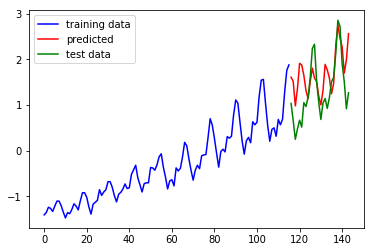

In [41]:
plot_results(train_data, predict, actual_vals, None)